# **Author: PHUNG QUANG HUY**

# **Student ID: pq15501y**

# **Custom Auto Encoder**


# Description

This script allows you to train, evaluate, sampling, and interpolate an AutoEncoder model in PyTorch on the MNIST dataset.

**Arguments**
- --mode: **Required.** Mode to run the AutoEncoder. Options: "train", "evaluate", "noisy", "sampling", "interpolate".
- --model: Path to the trained model.
- --alpha: Alpha value for interpolation. Only used in "interpolate" mode. Default is 0.5.
- --noise_level: Noise level for adding noise to the images. Default is 0.5.
- --latent_dim: Latent dimension for the AutoEncoder model. Default is 10.
- --lr: Learning rate for the AutoEncoder model. Default is 0.001.
- --epochs: Number of epochs for training the AutoEncoder model. Default is 10.
- --batch_size: Batch size for training the AutoEncoder model. Default is 64.

**Modes**
- train: Train the AutoEncoder model.
- evaluate: Evaluate the AutoEncoder model.
- sampling: Sample from the latent space of the AutoEncoder model.
- interpolate: Interpolate between two points in the latent space of the AutoEncoder model using the specified alpha value.
- noisy: Add noisy before reconstruct images.

**Usage**
``` $bash
python3 autoencoder.py --mode <mode> [--model <model>] [--alpha <alpha>] [--noise_level <noise_level>] [--latent_dim <latent_dim>] [--lr <lr>] [--epochs <epochs>] [--batch_size <batch_size>]
```

**Example**

***Custom Auto Encoder***

``` $bash
python3 autoencoder.py --mode train
python3 autoencoder.py --mode evaluate
python3 autoencoder.py --mode noisy
python3 autoencoder.py --mode sampling
python3 autoencoder.py --mode interpolate
```

***Custom Auto Encoder***
``` $bash
python3 VAE-autoencoder.py --mode train
python3 VAE-autoencoder.py --mode evaluate
python3 VAE-autoencoder.py --mode noisy
python3 VAE-autoencoder.py --mode sampling
python3 VAE-autoencoder.py --mode interpolate
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Custom Auto Encoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.latent = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, return_latent=False):
        x = self.encoder(x)
        x = self.latent(x)
        if return_latent:
            return x
        x = self.decoder(x)
        return x

In [4]:
class BaseModel():
    def __init__(self):
        super(BaseModel, self).__init__()

        self.device = device

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.latent_dim = 10
        self.lr = 0.001
        self.epochs = 10
        self.batch_size = 64
        self.noise_level = 0.5

        self.test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=self.transform, download=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=7, shuffle=True)

    def train(self, model):
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=self.transform, download=True)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        for epoch in range(self.epochs):
            running_loss = 0.0
            for images, _ in train_loader:
                images = images.to(self.device)

                optimizer.zero_grad()
                reconstructed_images = model(images)
                loss = criterion(reconstructed_images, images)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss:.4f}")

        torch.save(model.state_dict(), 'autoencoder_model.pth')

        print('Finished Training')

    @staticmethod
    def add_noise(images, noise_level):
        noise = torch.randn_like(images) - 0.5
        noisy_images = torch.clamp(images + 0.5 * noise_level, 0, 1)
        return noisy_images

    @staticmethod
    def save_output(plt, filename):
        if not os.path.exists('output'):
            os.makedirs('output')
        if not os.path.exists(os.path.join('output', 'custom_auto_encoder')):
            os.makedirs(os.path.join('output', 'custom_auto_encoder'))
        plt.savefig(os.path.join('output/custom_auto_encoder', filename))

    def evaluate(self, model):
        model.load_state_dict(torch.load('autoencoder_model.pth'))

        test_images, _ = next(iter(self.test_loader))
        test_images = test_images.to(self.device)

        reconstructed_images = model(test_images)

        fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(10, 6))

        for images, row in zip([test_images, reconstructed_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(img.cpu().detach().numpy().squeeze(), cmap='gray')
                ax.axis('off')

        axes[0, 0].set_title('Original')
        axes[1, 0].set_title('Reconstructed')

        self.save_output(plt, 'evaluation.png')

        plt.tight_layout()
        plt.show()

    def reconstruc_noisy_images(self, model):
        model.load_state_dict(torch.load('autoencoder_model.pth'))

        test_images, _ = next(iter(self.test_loader))
        test_images = test_images.to(self.device)

        noisy_images = self.add_noise(test_images, noise_level=0.5)

        reconstructed_noisy_images = model(noisy_images)

        fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

        for images, row in zip([test_images, noisy_images, reconstructed_noisy_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(img.cpu().detach().numpy().squeeze(), cmap='gray')
                ax.axis('off')

        axes[0, 0].set_title('Original')
        axes[1, 0].set_title('Noisy')
        axes[2, 0].set_title('Reconstructed (Noisy)')

        self.save_output(plt, 'reconstructed-noisy.png')

        plt.tight_layout()
        plt.show()

    def sample_latent_space(self, model):
        model.load_state_dict(torch.load('autoencoder_model.pth'))

        z = torch.randn(30, self.latent_dim, device=self.device)

        with torch.no_grad():
            fake_images = model.decoder(z).cpu()

        fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(15, 5))
        fig.suptitle("Sample Latent Space")
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(fake_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
            ax.axis('off')

        self.save_output(plt, 'sample_latent_space.png')

        plt.tight_layout()
        plt.show()

    def interpolate_latent(self, model, alpha=0.5):
        model.load_state_dict(torch.load('autoencoder_model.pth'))

        test_images, _ = next(iter(self.test_loader))
        test_images = test_images.to(self.device)
        image1, image2 = test_images[0:1], test_images[1:2]

        z1 = model(image1, return_latent=True)
        z2 = model(image2, return_latent=True)

        z = (1 - alpha) * z1 + alpha * z2

        with torch.no_grad():
            fake_images = model.decoder(z).cpu()

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        axes[0].imshow(image1.cpu().detach().numpy().squeeze(), cmap='gray')
        axes[0].set_title('Image 1')
        axes[1].imshow(image2.cpu().detach().numpy().squeeze(), cmap='gray')
        axes[1].set_title('Image 2')
        axes[2].imshow(fake_images[0].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[2].set_title('Interpolated Image')
        for ax in axes:
            ax.axis('off')

        self.save_output(plt, 'interpolate_latent.png')

        plt.tight_layout()
        plt.show()

> Initilize Model Instance

In [5]:
model = BaseModel()
auto_encoder_model = AutoEncoder(model.latent_dim).to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 99435353.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62927633.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36765144.84it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1478504.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



> Train

In [6]:
model.train(auto_encoder_model)

Epoch [1/10], Loss: 0.0332
Epoch [2/10], Loss: 0.0181
Epoch [3/10], Loss: 0.0162
Epoch [4/10], Loss: 0.0151
Epoch [5/10], Loss: 0.0144
Epoch [6/10], Loss: 0.0139
Epoch [7/10], Loss: 0.0135
Epoch [8/10], Loss: 0.0132
Epoch [9/10], Loss: 0.0130
Epoch [10/10], Loss: 0.0128
Finished Training


> Evaluate reconstructed images

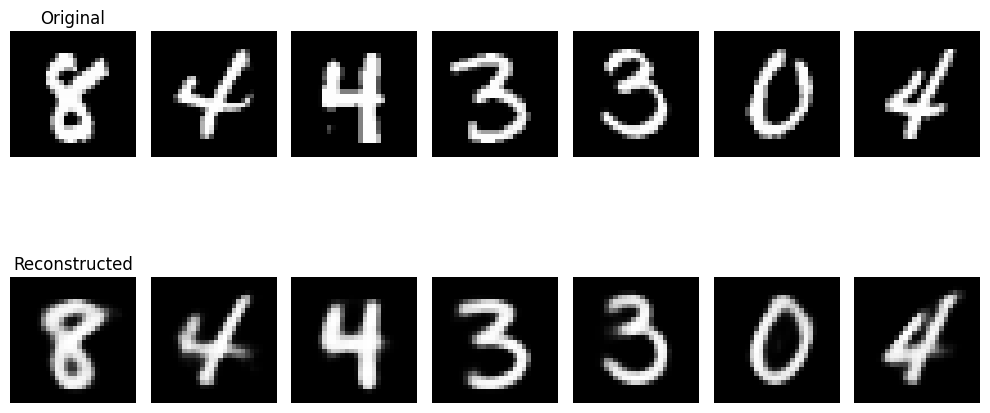

In [7]:
model.evaluate(auto_encoder_model)

> Evaluate reconstructed images after add noisy

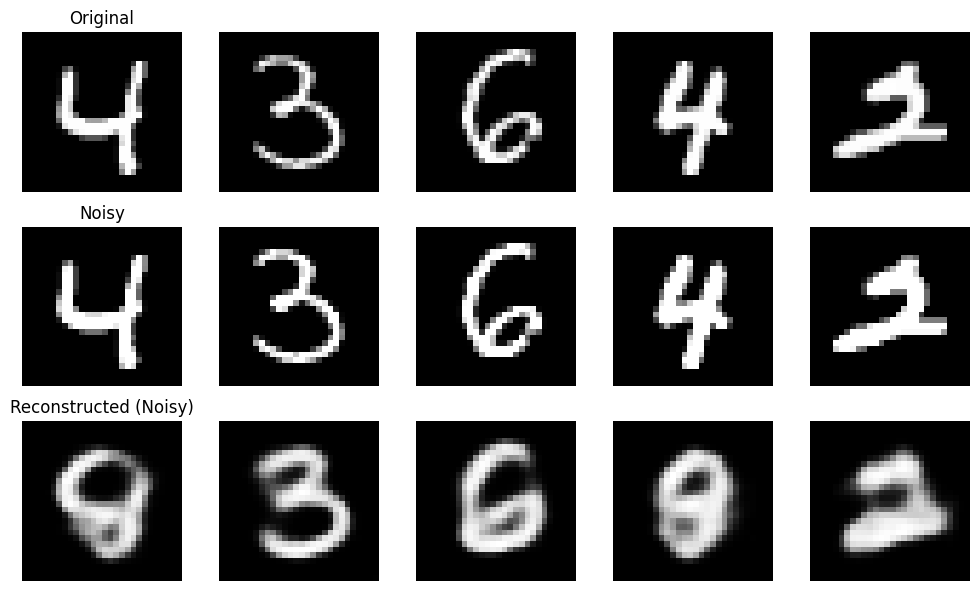

In [8]:
model.reconstruc_noisy_images(auto_encoder_model)

> Evaluate reconstructed images sampling laten space

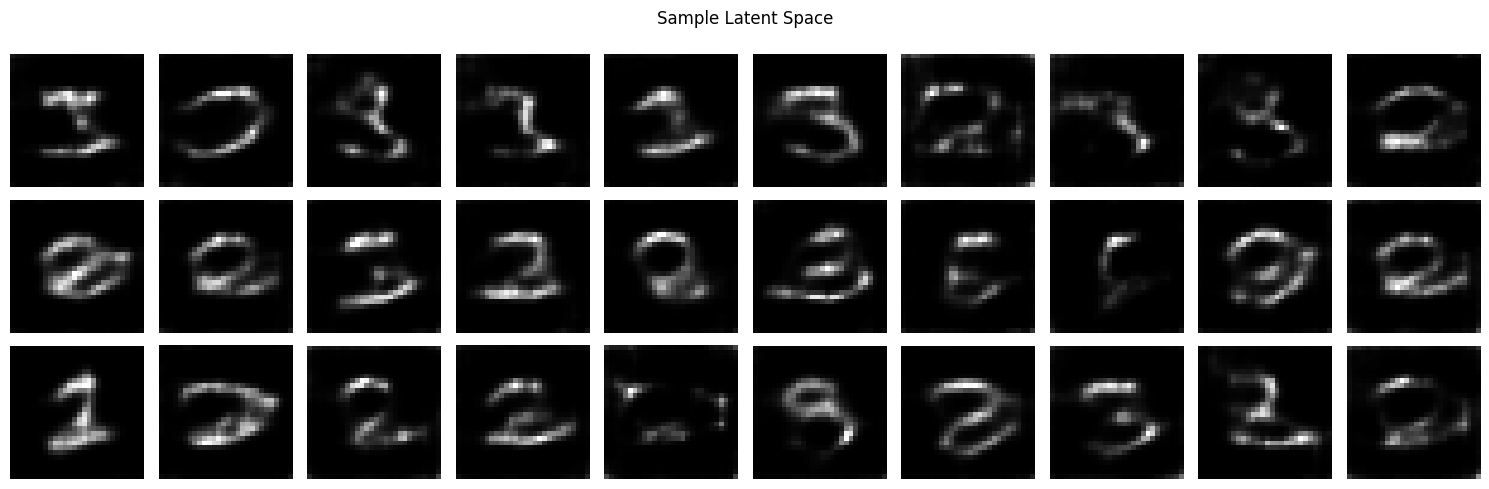

In [9]:
model.sample_latent_space(auto_encoder_model)

> Evaluate reconstructed images interpolate laten space

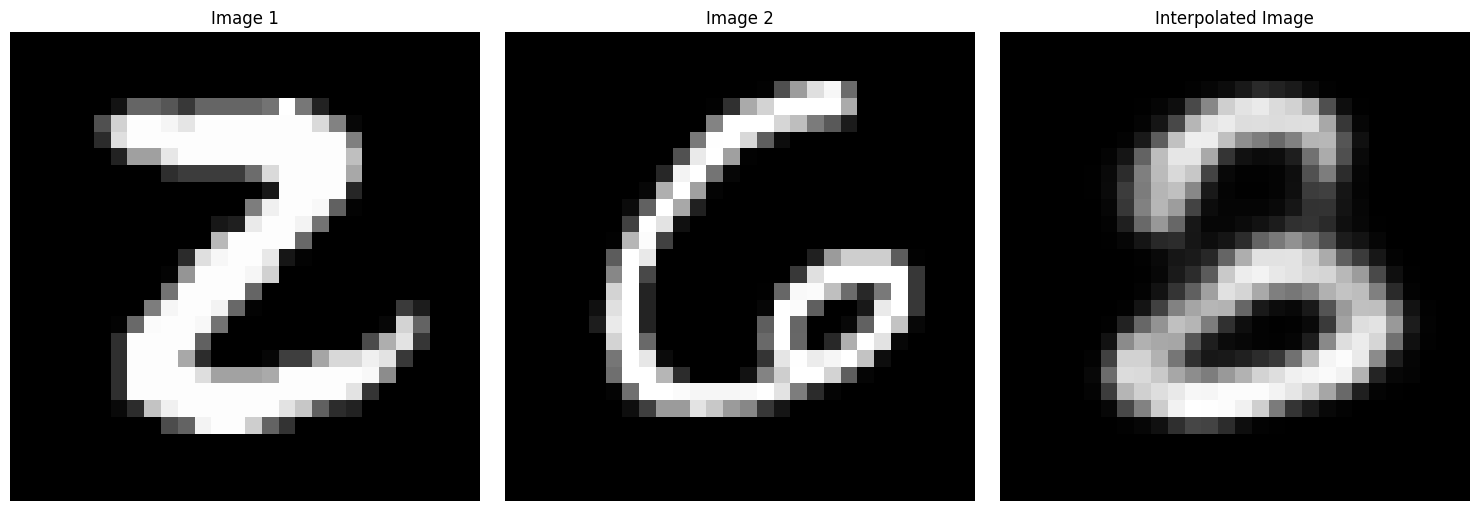

In [10]:
model.interpolate_latent(auto_encoder_model, alpha=0.5)

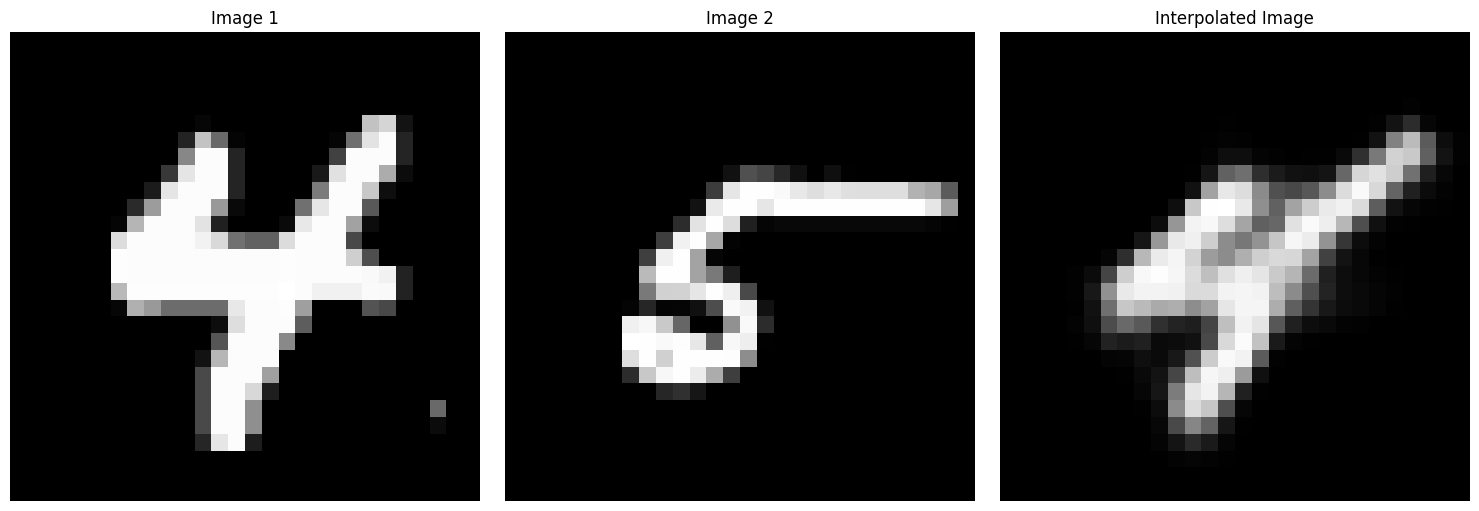

In [11]:
model.interpolate_latent(auto_encoder_model, alpha=0.5)

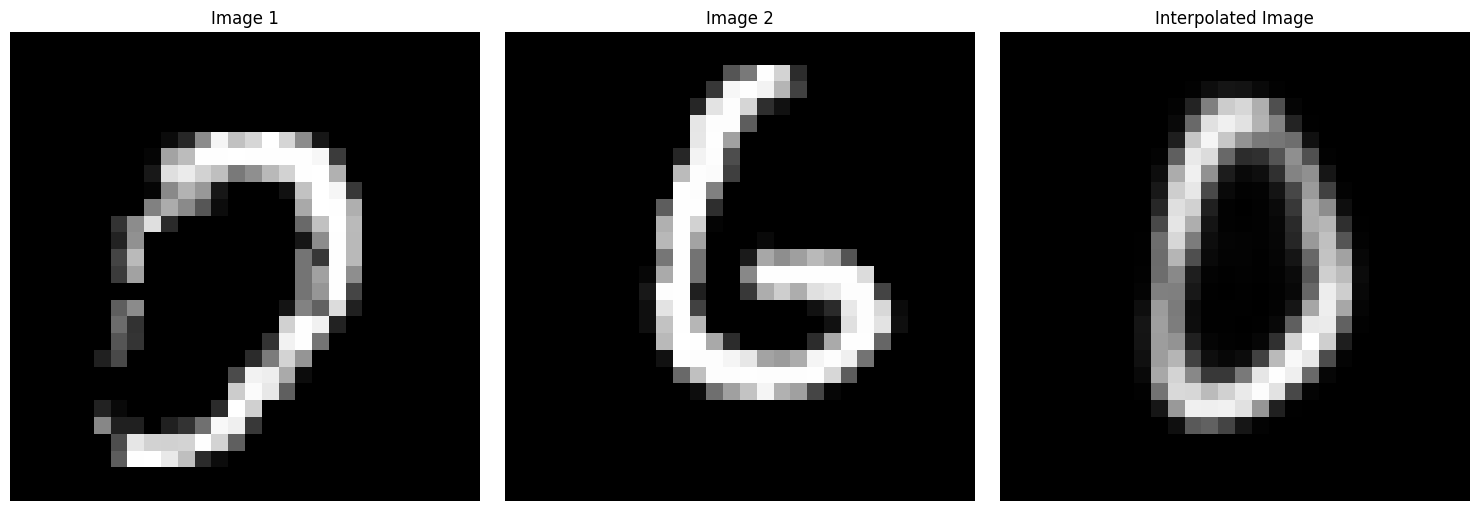

In [12]:
model.interpolate_latent(auto_encoder_model, alpha=0.5)